## Import libraries

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import cv2
from numpy import mean, std 
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split, GridSearchCV
#from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline
plt.style.use('bmh')

## 1. Load data

(270000, 8443) (8443,)


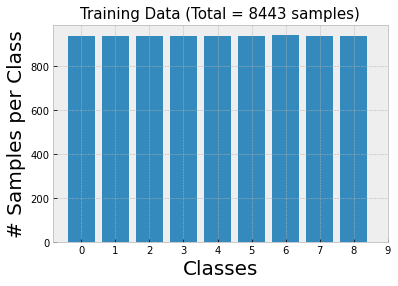

In [2]:
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

### 2. Visualising some images after and before preprocessing

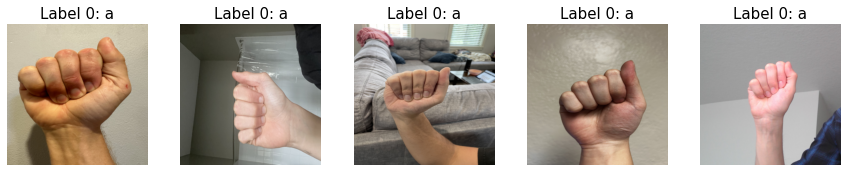

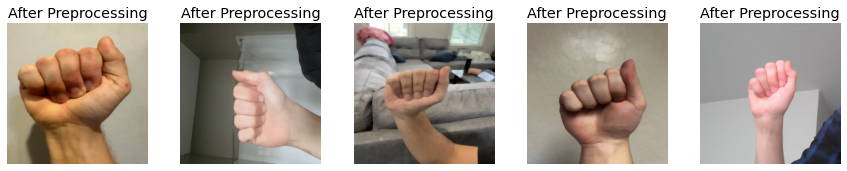

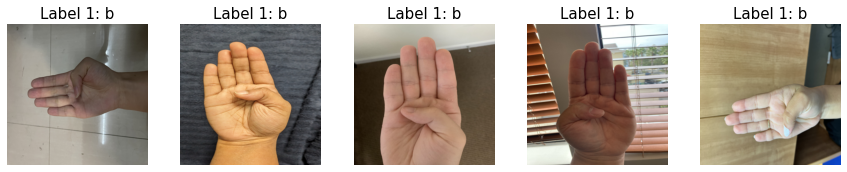

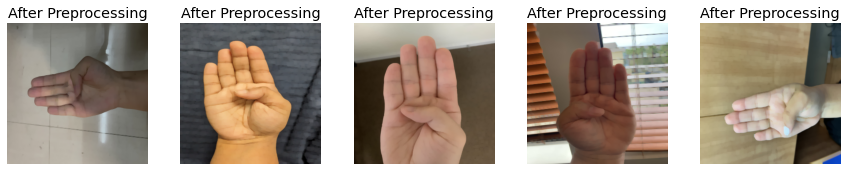

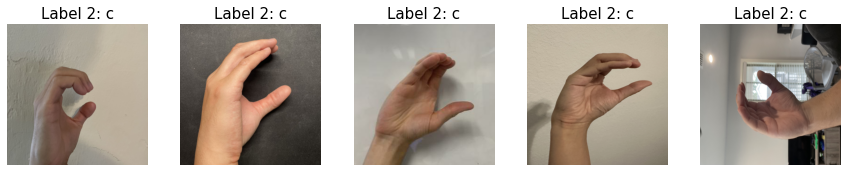

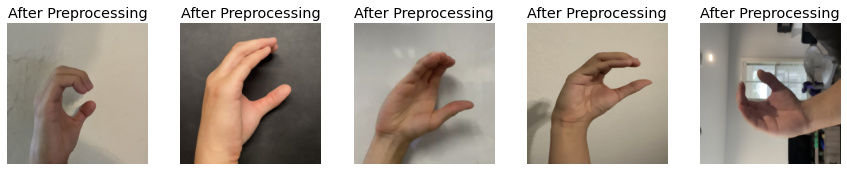

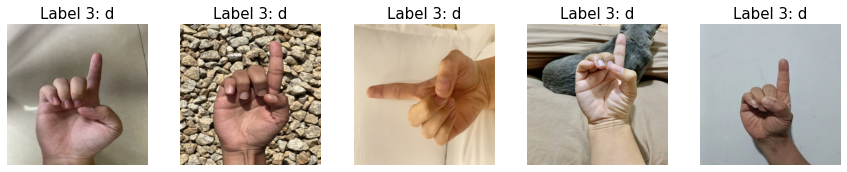

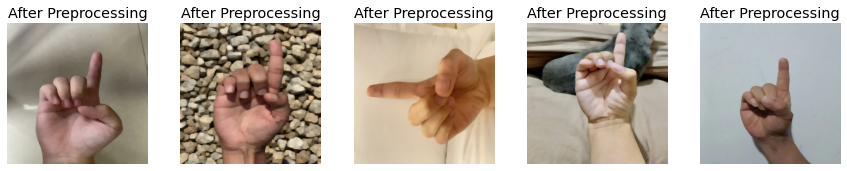

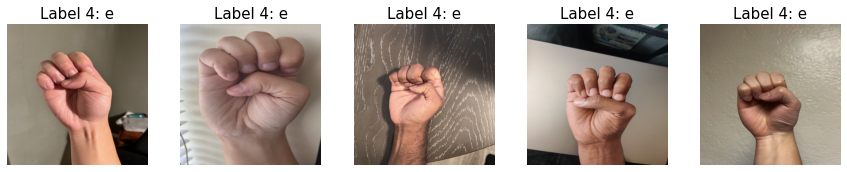

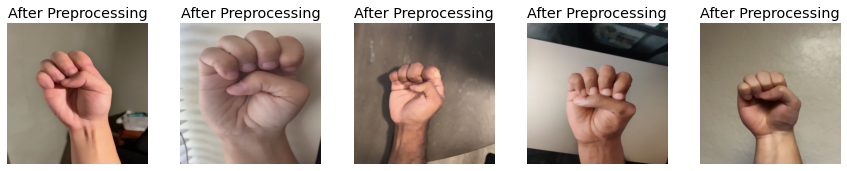

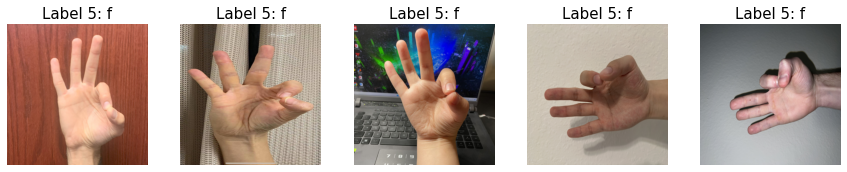

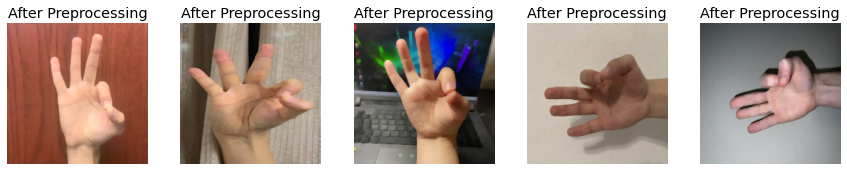

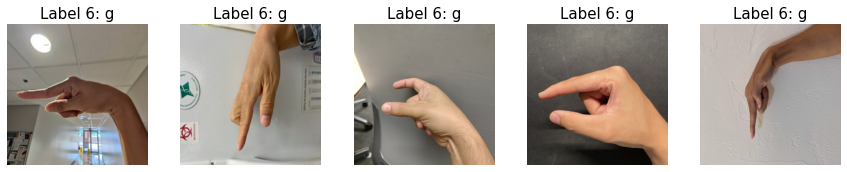

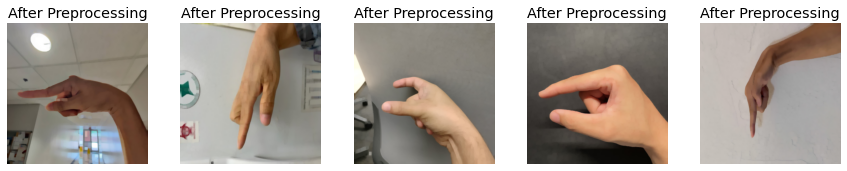

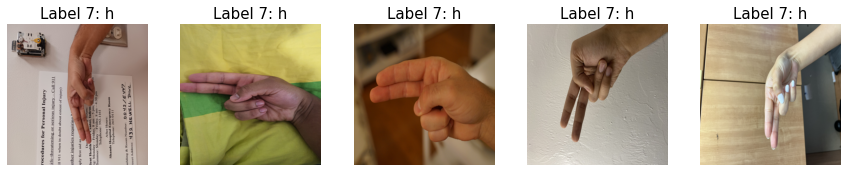

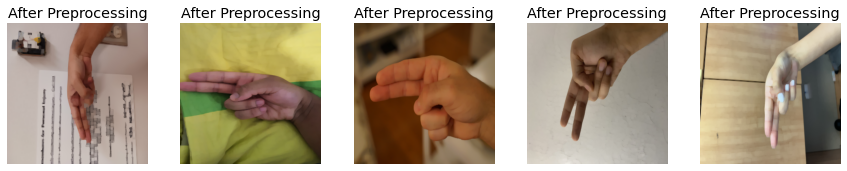

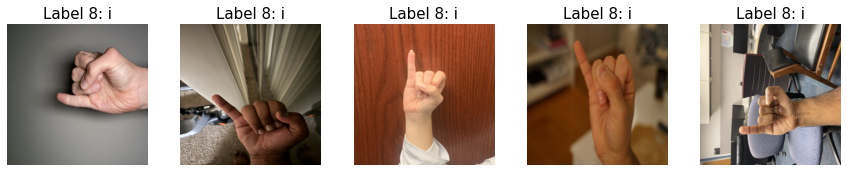

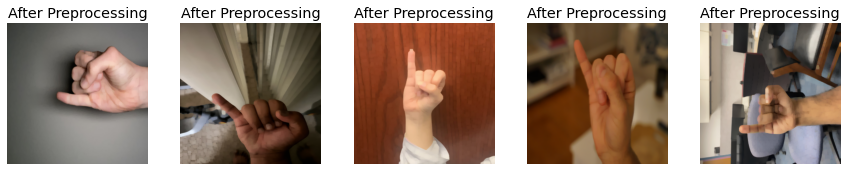

In [3]:
# Display and compare raw image data and preprocessed images
kernel = np.ones((5,5),np.uint8) # Create a 5x5 structuring element (matrix) for morphological operations

# Labels Integer Encoding 
labels_names = ['a',
                'b',
                'c',
                'd',
                'e',
                'f',
                'g',
                'h',
                'i']

# Displaying some examples per class
for i in range(0,9):
    rnd_sample = npr.permutation(np.where(labels_train==i)[0])
    fig_original = plt.figure(figsize=(15,15))
    
    for j in range(5):       
        fig_original.add_subplot(5,5,j+1)
        plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300,3))) # reshape to 300*300
        label_idx = int(labels_train[rnd_sample[j]])
        plt.axis('off');
        plt.title('Label '+str(label_idx)+': '+labels_names[label_idx],size=15)
    plt.show()
    print('\n\n')
    
    fig_preprocessed = plt.figure(figsize=(15,15)) 
    preprocessed_images = []    
    
    for j in range(5):
        fig_preprocessed.add_subplot(5,5,j+1)
        preprocessed_images.append(cv2.medianBlur((data_train[:,rnd_sample[j]].reshape((300,300,3))), 3))  # median blur
        preprocessed_images[j] = cv2.morphologyEx(preprocessed_images[j], cv2.MORPH_OPEN, kernel)  # Morphological
        #preprocessed_images[j] = cv2.cvtColor(preprocessed_images[j], cv2.COLOR_BGR2GRAY) # grayscale
        plt.imshow(preprocessed_images[j])
        plt.axis('off');
        plt.title('After Preprocessing')
    plt.show()
    print('\n\n')

### 3. Apply preprocessing and split training data

In [3]:
# Load and preprocess training data set
train_data_length = data_train.shape[1]
pre_shape = 210 # adjust preprocess data shape 

# load dataset
preprocessed_data = []
kernel = np.ones((4,4),np.uint8)  # Create a 4x4 structural matrix for morphological image processing

for i in range(train_data_length):
    preprocessed_data.append(data_train[:,i].reshape(300,300,3)) # Reshape each sample
    preprocessed_data[i] = cv2.medianBlur(preprocessed_data[i], 3)  # Median blur
    preprocessed_data[i] = cv2.morphologyEx(preprocessed_data[i], cv2.MORPH_OPEN, kernel) # morphological
    #preprocessed_data[i] = cv2.cvtColor(preprocessed_data[i], cv2.COLOR_BGR2GRAY) # grayscale
    preprocessed_data[i] = cv2.resize(preprocessed_data[i], (pre_shape,pre_shape), interpolation=cv2.INTER_AREA)
    
preprocessed_data = np.array(preprocessed_data)

### 4. Using 80-10-10 to split the training data

In [4]:
X_train, X_temp, t_train, t_temp = train_test_split(preprocessed_data, labels_train, 
                                                    test_size=0.2, 
                                                    stratify=labels_train,
                                                    shuffle=True,
                                                    random_state=0)

X_val, X_test, t_val, t_test = train_test_split(X_temp, t_temp, 
                                                    test_size=0.5, 
                                                    stratify=t_temp,
                                                    shuffle=True,
                                                    random_state=0)

### 5. Convert to float and normalize data to the range of 0-1

In [5]:
X_train = tf.constant(X_train, dtype=tf.float16)
X_val = tf.constant(X_val, dtype=tf.float16)
X_test = tf.constant(X_test, dtype=tf.float16)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape

2023-12-06 03:58:23.627331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 03:58:25.506561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-06 03:58:25.509636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


(TensorShape([6754, 210, 210, 3]),
 (6754,),
 TensorShape([844, 210, 210, 3]),
 (844,),
 TensorShape([845, 210, 210, 3]),
 (845,))

## 6. Define our CNN model

In [4]:
# Transfer learning model
def define_model(lr, shape):
    base_model = keras.applications.VGG16(
        weights='imagenet', 
        input_tensor=keras.layers.Input(shape=(shape, shape, 3)),
        include_top=False, 
    )

    base_model.trainable = False
    inputs = keras.Input(shape=(shape, shape, 3))
    inputs = keras.layers.BatchNormalization()(inputs)

    x_model = base_model(inputs)
    #x_model = keras.layers.GlobalAveragePooling2D()(x_model)
    dropout1 = keras.layers.Dropout(0.5)(x_model)
    x_flatten = keras.layers.Flatten()(dropout1)
    layer1 = keras.layers.Dense(256, activation="relu", kernel_initializer='he_uniform',)(x_flatten)
    #dropout1 = keras.layers.Dropout(0.5)(layer1)
    #layer2 = keras.layers.Dense(64, activation="relu", kernel_initializer='he_uniform')(dropout1) # lecun_normal
    dropout2 = keras.layers.Dropout(0.7)(layer1)
    outputs = keras.layers.Dense(9, activation="softmax")(dropout2)
    model = keras.Model(inputs, outputs)

    opt = keras.optimizers.Nadam(learning_rate=lr)
    model.compile(optimizer=opt, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 7. Evaluate performance method

In [8]:
def Evaluate(histories):
    for history in histories:
        plt.figure(figsize=(12, 7))

        # Plot accuracy
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Training and Validation Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Accuracy', 'Val Accuracy'], loc='lower right')
        plt.show()

        # Plot loss
        plt.figure(figsize=(12, 7))
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Training and Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Loss', 'Val Loss'], loc='upper right')
        plt.show()

### 8. Learning rate tuning by grid search (No need run since it cost too much time)

In [ ]:
# Function for Finding best parameters using GRID CV
parameters = {'learn_rate':[0.0001, 0.00005, 0.00001]}
model = KerasClassifier(build_fn = define_model, epochs = 200, batch_size = 32)
grid = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = 1, cv = 3, verbose = 2, return_train_score = True)
grid_result = grid.fit(X_train, t_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
best_estimator = grid_result.best_estimator_
print(best_estimator.get_params())

### 9. Use the best parameters above to train our model 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 210, 210, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 6, 6, 512)         0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313  

2023-12-06 01:01:21.247284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


  1/212 [..............................] - ETA: 31:25 - loss: 3.3997 - accuracy: 0.1875

2023-12-06 01:01:27.554327: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


212/212 [==============================] - 47s 182ms/step - loss: 2.9108 - accuracy: 0.1306 - val_loss: 2.1098 - val_accuracy: 0.2453
Epoch 2/200
212/212 [==============================] - 38s 179ms/step - loss: 2.3542 - accuracy: 0.1492 - val_loss: 2.1298 - val_accuracy: 0.3400
Epoch 3/200
212/212 [==============================] - 38s 179ms/step - loss: 2.2178 - accuracy: 0.1722 - val_loss: 2.1325 - val_accuracy: 0.3590
Epoch 4/200
212/212 [==============================] - 38s 180ms/step - loss: 2.1394 - accuracy: 0.1908 - val_loss: 2.1065 - val_accuracy: 0.3874
Epoch 5/200
212/212 [==============================] - 38s 180ms/step - loss: 2.0800 - accuracy: 0.2145 - val_loss: 2.0311 - val_accuracy: 0.4893
Epoch 6/200
212/212 [==============================] - 38s 179ms/step - loss: 2.0329 - accuracy: 0.2419 - val_loss: 1.9441 - val_accuracy: 0.5438
Epoch 7/200
212/212 [==============================] - 38s 180ms/step - loss: 1.9621 - accuracy: 0.2729 - val_loss: 1.8347 - val_accurac

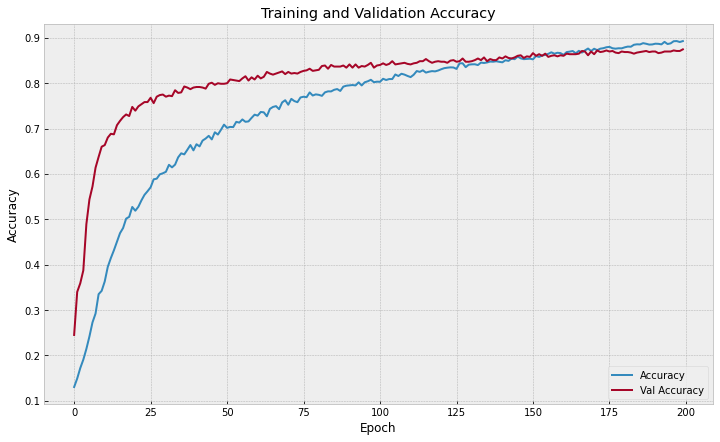

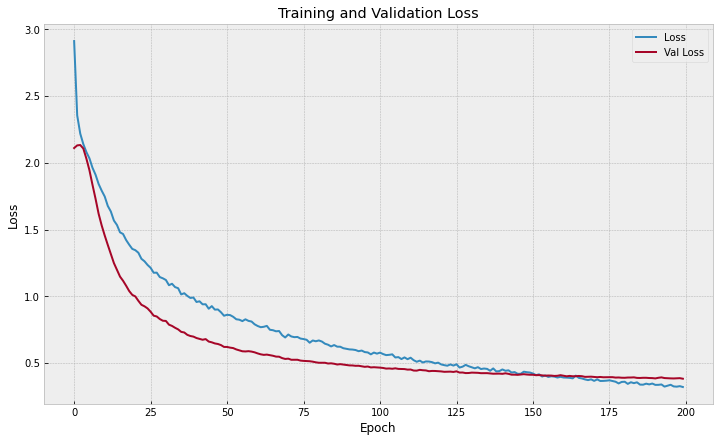

In [9]:
# Run and evaluate model
best_lr = 0.00001
model = define_model(best_lr, pre_shape)  # best learning rate
print(model.summary())

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
cp = keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

# Data augmentation using ImageDataGenerator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # Random rotations up to 10 degrees
#    zoom_range=0.2, # Random zooms up to 20%
#    horizontal_flip=True,  # Random horizontal flips
#    vertical_flip=True,  # Random vertical flips
)

datagen.fit(X_train)  # Fit the ImageDataGenerator on the training data

# Fit model
history = model.fit(datagen.flow(X_train, t_train, batch_size=32),
#history = model.fit(X_train, t_train, batch_size=32,
                    epochs=200,
                    validation_data=(X_val, t_val), 
                    verbose=1, 
                    callbacks=[es, cp])

Evaluate([history.history])

### 10. Evaluate test set performance method

In [5]:
def Evaluate_performance(model, name, X_test, t_test):
    # Prediction
    y_test = np.argmax(model.predict(X_test), axis=1)
    
    # Print performance
    print(f'{name} Performance:\n')
    print('Test set:')
    print(f'{classification_report(t_test, y_test)}')
    print(f'Accuracy: {accuracy_score(y_test, t_test)}')
    print('Confusion Matrix')
    print(confusion_matrix(t_test, y_test))

### 11. Small sample test on 10% of training data

In [11]:
model = keras.models.load_model('model.h5')
print(model.summary())
Evaluate_performance(model=model, name='Transfer learning with VGG16' , X_test=X_test, t_test=t_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 210, 210, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 6, 6, 512)         0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313  

### 12. Use same model structure to generate the final model with full training set (If you have kernel died on this step, try to re-run import libraries, step 1, 3, 6 and then run this cell)

2023-12-06 04:00:27.816850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 04:00:29.601067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-06 04:00:29.604109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


Epoch 1/200


2023-12-06 04:00:38.516144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


 13/264 [>.............................] - ETA: 3s - loss: 3.7620 - accuracy: 0.1082

2023-12-06 04:00:45.786409: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - 14s 18ms/step - loss: 2.9255 - accuracy: 0.1227
Epoch 2/200
264/264 [==============================] - 4s 15ms/step - loss: 2.3045 - accuracy: 0.1552
Epoch 3/200
264/264 [==============================] - 4s 15ms/step - loss: 2.1667 - accuracy: 0.1918
Epoch 4/200
264/264 [==============================] - 4s 15ms/step - loss: 2.0865 - accuracy: 0.2207
Epoch 5/200
264/264 [==============================] - 4s 15ms/step - loss: 1.9995 - accuracy: 0.2622
Epoch 6/200
264/264 [==============================] - 4s 15ms/step - loss: 1.9172 - accuracy: 0.2949
Epoch 7/200
264/264 [==============================] - 4s 15ms/step - loss: 1.8347 - accuracy: 0.3319
Epoch 8/200
264/264 [==============================] - 4s 15ms/step - loss: 1.7494 - accuracy: 0.3623
Epoch 9/200
264/264 [==============================] - 4s 15ms/step - loss: 1.6872 - accuracy: 0.3892
Epoch 10/200
264/264 [==============================] - 4s 15ms/step - loss: 1.6165 - accurac

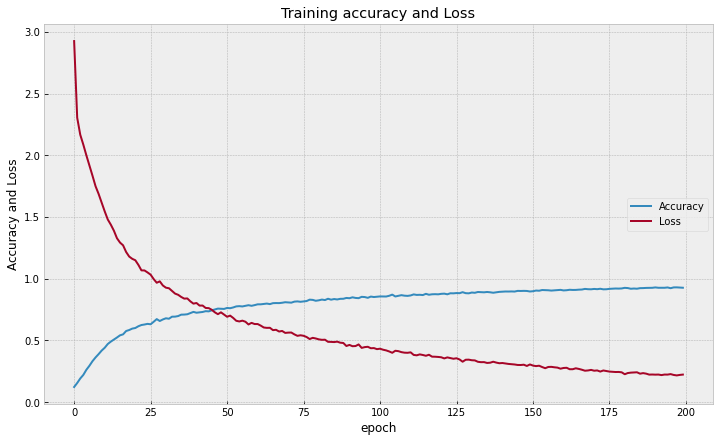

In [5]:
# Run and evaluate model
final_model = define_model(0.00001, pre_shape)

X_train_f = tf.constant(preprocessed_data, dtype=tf.float16)
X_train_f = X_train_f / 255.0

cp_f = keras.callbacks.ModelCheckpoint('Robotboy_model.h5', monitor='loss', save_best_only=True)

history_f = final_model.fit(X_train_f, labels_train, batch_size=32,
                    epochs=200,
                    verbose=1, 
                    callbacks=[cp_f])

plt.figure(figsize=(12,7))
plt.plot(history_f.history['accuracy'])
plt.plot(history_f.history['loss'])
plt.title('Training accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='center right')
plt.show()